In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dask import delayed
from math import sqrt
import dask.array as da
import h5py, time

In [2]:
final = pd.read_csv('telco_data.csv')

In [3]:
final.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Examining object memory usage

In [4]:
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

In [5]:
final.memory_usage() // 1024

Index                0
customerID          55
gender              55
SeniorCitizen       55
Partner             55
Dependents          55
tenure              55
PhoneService        55
MultipleLines       55
InternetService     55
OnlineSecurity      55
OnlineBackup        55
DeviceProtection    55
TechSupport         55
StreamingTV         55
StreamingMovies     55
Contract            55
PaperlessBilling    55
PaymentMethod       55
MonthlyCharges      55
TotalCharges        55
Churn               55
dtype: int64

## Reading a df in chunks

In [6]:
def filter_for_var(data):
    ''' Returns a df filtering for a condition '''
    var_filter = (data.tenure >20)
    return data.loc[var_filter]

# list of dfs called chunks
chunks = []

# for-loop
#for chunk in pd.read_csv('telco_data.csv', chunksize=1000):
#    chunks.append(filter_for_var(chunk))
    
# list comprehension
chunks = [filter_for_var(chunk)
          for chunk in pd.read_csv('telco_data.csv', chunksize=1000)]


In [7]:
lengths = [len(chunk) for chunk in chunks]
lengths

[588, 595, 602, 559, 602, 584, 610, 25]

In [8]:
newdat = pd.concat(chunks)
newdat.shape

(4165, 21)

### Plot data

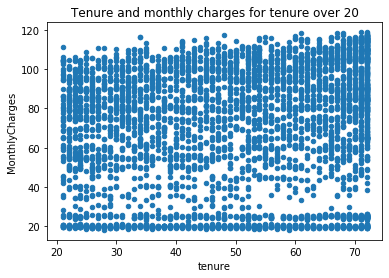

In [9]:
newdat.plot.scatter(x='tenure', y='MonthlyCharges')
plt.xlabel('tenure')
plt.ylabel('MonthlyCharges')
plt.title('Tenure and monthly charges for tenure over 20')
plt.show()

## Managing data with Generators
Very similar to list comprehension used above. But they use lazy evaluation. Elements are generated one at the time so they are never in memory simultaneously. This is helpful when operating at the limits of available memory. No reading or work is done until the very last step. 

In [10]:
chunks = (filter_for_var(chunk)
         for chunk in pd.read_csv('telco_data.csv', chunksize=1000))

charges = (chunk['MonthlyCharges'].sum() for chunk in chunks)

sum(charges)

291394.3

## Delaying computation with Dask

In [11]:
def f(z):
    return sqrt(z + 4)
def g(y):
    return y - 3
def h(x):
    return x**2

In [12]:
x = 4
y = h(x)
z = g(y)
w = f(z)
print(w)

4.123105625617661


Use a "delayed" from Dask. This is a higher-order (or a decorator) function that maps an input function to another modified output function. The result is a dask delayed object rather than a value, and the actual computation is only done when 'compute' is invoked.

In [13]:
y = delayed(h)(x)
z = delayed(g)(y)
w = delayed(h)(z)
print(w)
print(type(w))

Delayed('h-6fd5ed58-e48a-412f-9c7b-a52e73b2b233')
<class 'dask.delayed.Delayed'>


In [14]:
w.compute()

169

### Deferring computation within loops

In [15]:
@delayed
def increment(x):
    return x + 1

@delayed
def double(x):
    return 2 * x

@delayed
def add(x, y):
    return x + y


In [16]:
data = [1, 2, 3, 4, 5]
output = []

for x in data:
    a = increment(x)
    b = double(x)
    c = add(a, b)
    output.append(c)
    
total = sum(output)    

The result is that total is a delayed object, output is a list of intermediate delayed objects, and total_sum is the final sum, where calculation is delayed until the very end. 

In [17]:
total

Delayed('add-528f1a56ead755dcacbf7f5e17c74e4b')

In [18]:
output

[Delayed('add-2e4ae4e8-a643-4ae4-b1fc-fce59bc5c013'),
 Delayed('add-7683da30-7a7b-44ea-82d3-818b24fc29b0'),
 Delayed('add-00521b9e-df8e-4f65-a331-dd4758e16a10'),
 Delayed('add-eb350071-ad38-4583-86f2-b2191d0c0f27'),
 Delayed('add-e338d1ec-2ef4-4740-a0c7-47b444121d6f')]

In [19]:
total_sum = total.compute()
print(total_sum)

50


## Using a dask pipeline with delayed

Below is a slightly modified version of the functions used before. Again, no calculations are done until the very end when compute is called. 

In [20]:
# Define count_cases
@delayed
def count_cases(df):
    return len(df)

# Define count_female
@delayed
def count_female(df):
    return (df['gender']=='Female').sum()

# Define pct_females
@delayed
def pct_females(n_females, n_cases):
    return round(100 * sum(n_females) / sum(n_cases), 2)

In [21]:
n_cases = []
n_females = []

for chunk in pd.read_csv('telco_data.csv', chunksize=1000):
    n_cases.append(count_cases(chunk))
    n_females.append(count_female(chunk))
    
result = pct_females(n_females, n_cases)

In [22]:
print(type(result))
print(result.compute())

<class 'dask.delayed.Delayed'>
49.52


## Dask arrays

In [23]:
a = np.random.rand(10000)

In [24]:
a_dask = da.from_array(a, chunks=len(a) // 4) # chunks elements in each peace of a
print(a_dask.chunks)

((2500, 2500, 2500, 2500),)


In [25]:
n_chunks = 4
chunk_size = len(a) // n_chunks
result = 0 # accumulate sum

for k in range(n_chunks):
    offset = k * chunk_size # track offset
    a_chunk = a[offset:offset + chunk_size] # slice chunk
    result += a_chunk.sum()

Dask version of the above

In [26]:
a_dask = da.from_array(a, chunks = len(a) // n_chunks)
result = a_dask.sum()
result

dask.array<sum-aggregate, shape=(), dtype=float64, chunksize=()>

In [27]:
print(result.compute())

4945.215385584371


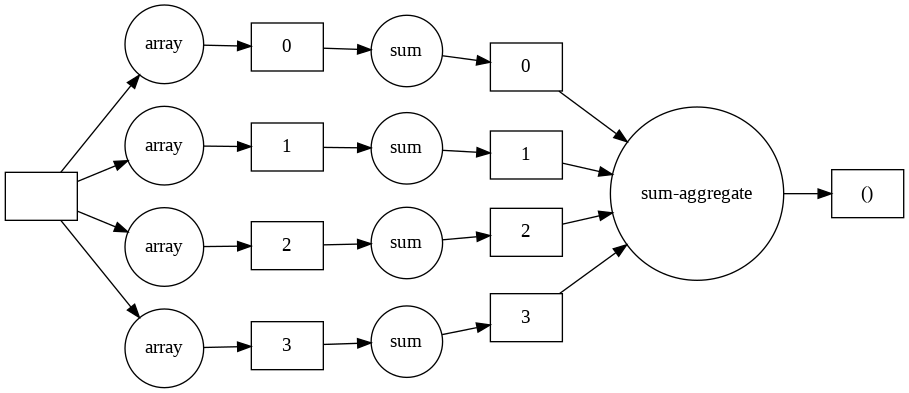

In [28]:
result.visualize(rankdir='LR') # forces horizontal layout